[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/model-training/training-with-wandb/00-intro-and-summarizer-train.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/model-training/training-with-wandb/00-intro-and-summarizer-train.ipynb)

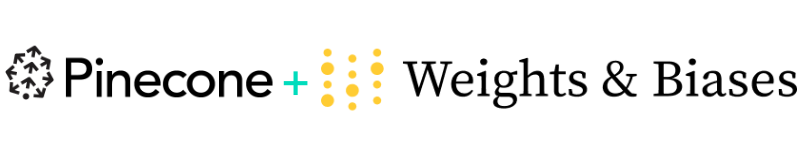

This is part *one* of a four-part notebook series on fine-tuning encoder models with Weights & Biases for use with Pinecone. Find the [full set of notebooks on Github here](https://github.com/pinecone-io/examples/blob/master/analytics-and-ml/model-training/training-with-wandb).

<!--- @wandbcode{wandb-pinecone} -->

## What this notebook covers

In this notebook we show you how to integrate
[Weights & Biases](https://wandb.ai/site)
with your
[SimpleTransformers](https://github.com/UKPLab/sentence-transformers) 
code to add experiment tracking to your pipeline. We'll ready our data for use in the Pinecone.io ecosystem, which enables you to make search, recommender systems, and more in a matter of minutes.

This Notebook includes:

1. dataset and model versioning with W&B,
[Artifacts](https://docs.wandb.ai/guides/artifacts)
2. storing configuration, hyperparameters (including hyperparameter sweeps!), system metrics, and model metrics in an [interactive dashboard](https://docs.wandb.ai/guides/track/app), and
3. examining evaluation outputs of your model using
[W&B Tables](https://docs.wandb.ai/guides/data-vis).

We'll take a dataset of arXiv papers, show you how to use Artifacts to create data and model lineages, and then fine-tune a model to make new title predictions for some arXiv papers. Finally, we'll show you how to leverage **Hyperparameter Sweeps** to 

- increase your model's performance
- reduce infrastructure and/or cloud spend costs, while
- improving reproducibility


## 🤔 Why should I use W&B?

<img src="https://wandb.me/mini-diagram" width="650">

- **Unified dashboard**: Central repository for all your model metrics and predictions
- **Lightweight**: No code changes required to integrate with Hugging Face
- **Accessible**: Free for individuals and academic teams
- **Secure**: All projects are private by default
- **Trusted**: Used by machine learning teams at OpenAI, Toyota, Lyft and more

Think of W&B like GitHub for machine learning models — save machine learning experiments to your private, hosted dashboard. Experiment quickly with the confidence that all the versions of your models are saved for you, no matter where you're running your scripts.

W&B lightweight integrations works with any Python script, and all you need to do is sign up for a free W&B account to start tracking and visualizing your models.

In the `simpletransformers` repo, Weights & Biases engineers have instrumented the Trainer to automatically log training and evaluation metrics to W&B at each logging step.

Here's an in depth look at how the integration works: [Simple Transformers + W&B Report](https://wandb.ai/jxmorris12/huggingface-demo/reports/Train-a-model-with-Hugging-Face-and-Weights-&-Biases--VmlldzoxMDE2MTU)

# Prereqs

A Weights & Biases account; sign up here: https://app.wandb.ai/login?signup=true

In [ ]:
!pip install -qq wandb pinecone-client GPUtil datasets transformers rouge-score nltk evaluate

In [ ]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


# Change the `WANDB_ENTITY` value below to your username

In [ ]:
# Only needed if you don't checkin the wandb/settings file
WANDB_ENTITY='andrea0' 
WANDB_PROJECT='paper-summaries-demo'

In [ ]:
#import needed libraries
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import numpy as np
import evaluate

import wandb

Please see the `Outside a run` tab in this section, [Download and use an Artifact](https://docs.wandb.ai/guides/artifacts/download-and-use-an-artifact#download-and-use-an-artifact-stored-on-weights-and-biases), for more information on downloading artifacts **inside** and **outside** of a run: https://docs.wandb.ai/guides/artifacts/download-and-use-an-artifact#download-and-use-an-artifact-stored-on-weights-and-biases

## Pull down some curated training data

In this Notebook we'll be using a summarization model to generate some new titles for papers. I don't know about you, but I have a hard time remembering the papers with pun-ny titles. If I could have a nice one-sentence "replacement title" that really summarizes what the paper is about that would help me with my literature reviews and keeping up on research!

We've preprocessed a large dataset down into train and test files. To log this process - **for reproducibility** - we use W&Bs `Artifacts`:

In [ ]:
api = wandb.Api()
train_artifact = api.artifact('events/papers-arxiv-data/train-bifurcated.csv:latest')
test_artifact = api.artifact('events/papers-arxiv-data/test-bifurcated.csv:latest')
train_artifact.download()
test_artifact.download()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


'./artifacts/test-bifurcated.csv:v0'

Please see the `Outside a run` tab in this section, [Download and use an Artifact](https://docs.wandb.ai/guides/artifacts/download-and-use-an-artifact#download-and-use-an-artifact-stored-on-weights-and-biases), for more information on downloading artifacts **inside** and **outside** of a run.

Image source: https://wandb.ai/events/arxiv-searching/artifacts/dataset/arxiv-papers/v0

<img src="https://i.imgur.com/4bcJpdw.png" width="80%" alt="An Artifact Model Card page showing metadata" />



<img src="https://i.imgur.com/ZxTDMfz.png" width="80%" alt="An Artifact showing train and test lineage" />

Directed graph image source: https://wandb.ai/events/papers-arxiv-data/artifacts/dataset/arxiv-fewer-years/v0/lineage

# Fine-tuning a model on a summarization task

In this notebook, we will see how to fine-tune one of the Transformer's models for a summarization task. 

Like we said before, we'll use the [Cornell arXiv dataset](https://wandb.ai/events/arxiv-searching/artifacts/dataset/arxiv-papers/v0) which contains abstracts (a paragraph) of scholarly articles accompanied by a paper title.

We're going to generate new, better-fitting paper titles so that we don't have to memorize all of the [Sesame Street characters](https://www.theverge.com/2019/12/11/20993407/ai-language-models-muppets-sesame-street-muppetware-elmo-bert-ernie).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#import needed libraries
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import numpy as np
import evaluate

model_checkpoint = "t5-small"

In [ ]:
from datasets import load_dataset, load_metric

metric = load_metric("rouge")

data_files = {"train": "/content/artifacts/train-bifurcated.csv:v0/train-bifurcated.csv", "test": "/content/artifacts/test-bifurcated.csv:v0/test-bifurcated.csv"}
dataset = load_dataset("/content/", data_files=data_files)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Peek at a single record
dataset["train"][0]

{'Unnamed: 0': 5363,
 'doi': '10.1090/proc/15508',
 'title': 'On a class of Hessian type equations on Riemannian manifolds',
 'abstract': '  In this paper, we consider a class of Hessian type equations which include\nthe $(n-1)$ Monge-Amp\\`{e}re equation on Riemannian manifolds. The \\emph{a\npriori} $C^2$ estimates and the existence of solutions are established.\n',
 'year': 2021,
 'cat_all': "['math.AP']"}

In [ ]:
# Leave just the two text data columns, paper title and paper abstract
dataset["train"] = dataset["train"].remove_columns(['Unnamed: 0', 'doi', 'year', 'cat_all'])
dataset["test"] = dataset["test"].remove_columns(['Unnamed: 0', 'doi', 'year', 'cat_all'])

## Let's peek at some more data

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_arxiv_data(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Error. Cannot pick more records than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_arxiv_data(dataset["train"])

,title,abstract
0,Design and Simulation of a Hybrid Architecture for Edge Computing in 5G\n and Beyond,"Edge Computing in 5G and Beyond is a promising solution for ultra-low latency\napplications (e.g. Autonomous Vehicle, Augmented Reality, and Remote Surgery),\nwhich have an extraordinarily low tolerance for the delay and require fast data\nprocessing for a very high volume of data. The requirements of delay-sensitive\napplications (e.g. Low latency, proximity, and Location/Context-awareness)\ncannot be satisfied by Cloud Computing due to the high latency between User\nEquipment and Cloud. Nevertheless, Edge Computing in 5G and beyond can promise\nan ultra-high-speed caused by placing computation capabilities closer to\nendpoint devices, whereas 5G encourages the speed rate that is 200 times faster\nthan 4G LTE-Advanced. This paper deeply investigates Edge Computing in 5G and\ncharacterizes it based on the requirements of ultra-low latency applications.\nAs a contribution, we propose a hybrid architecture that takes advantage of\nnovel and sustainable technologies (e.g. D2D communication, Massive MIMO, SDN,\nand NFV) and has major features such as scalability, reliability and ultra-low\nlatency support. The proposed architecture is evaluated based on an agent-based\nsimulation that demonstrates it can satisfy requirements and has the ability to\nrespond to high volume demands with low latency.\n"
1,Least-squares fitting applied to nuclear mass formulas. Resolution by\n the Gauss-Seidel method,"A numerical method optimizing the coefficients of the semi empirical mass\nformula or those of similar mass formulas is presented. The optimization is\nbased on the least-squares adjustments method and leads to the resolution of a\nlinear system which is solved by iterations according to the Gauss-Seidel\nscheme. The steps of the algorithm are given in detail. In practice the method\nis very simple to implement and is able to treat large data in a very fast way.\nIn fact, although this method has been illustrated here by specific examples,\nit can be applied without difficulty to any experimental or statistical data of\nthe same type, i.e. those leading to linear system characterized by symmetric\nand positive-definite matrices.\n"
2,Projection-based Classification of Surfaces for 3D Human Mesh Sequence\n Retrieval,"We analyze human poses and motion by introducing three sequences of easily\ncalculated surface descriptors that are invariant under reparametrizations and\nEuclidean transformations. These descriptors are obtained by associating to\neach finitely-triangulated surface two functions on the unit sphere: for each\nunit vector u we compute the weighted area of the projection of the surface\nonto the plane orthogonal to u and the length of its projection onto the line\nspanned by u. The L2 norms and inner products of the projections of these\nfunctions onto the space of spherical harmonics of order k provide us with\nthree sequences of Euclidean and reparametrization invariants of the surface.\nThe use of these invariants reduces the comparison of 3D+time surface\nrepresentations to the comparison of polygonal curves in R^n. The experimental\nresults on the FAUST and CVSSP3D artificial datasets are promising. Moreover, a\nslight modification of our method yields good results on the noisy CVSSP3D real\ndataset.\n"
3,The Spatio-Temporal Poisson Point Process: A Simple Model for the\n Alignment of Event Camera Data,"Event cameras, inspired by biological vision systems, provide a natural and\ndata efficient representation of visual information. Visual information is\nacquired in the form of events that are triggered by local brightness changes.\nEach pixel location of the camera's sensor records events asynchronously and\nindependently with very high temporal resolution. However, because most\nbrightness changes are triggered by relative motion of the camera and the\nscene, the events recorded at a single sensor location seldom corres

In [ ]:
# from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

# model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
tokenizer= AutoTokenizer.from_pretrained(model_checkpoint)

device= torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)


max_input_length = 1024 #This is the abstract
max_target_length = 128 #This is the paper title

# Summarization models need to put `Summarize:` in front of text:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["abstract"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["title"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

#apply the tokenization and text preparation to the data
#setting batched to true allows for this to be doen faster
tokenized_datasets = dataset.map(preprocess_function, batched=True, batch_size=200)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/d78aea13fa7ecd06c29e3e46195d6341255065d5/config.json
Model config T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_b

  0%|          | 0/9 [00:00<?, ?ba/s]

# For a review of Transformers, Attention-based models

Please see Jay Alammar's ["The Illustrated Transformer"](https://jalammar.github.io/illustrated-transformer/) for a stellar write-up on Transformers, Attention, etc.

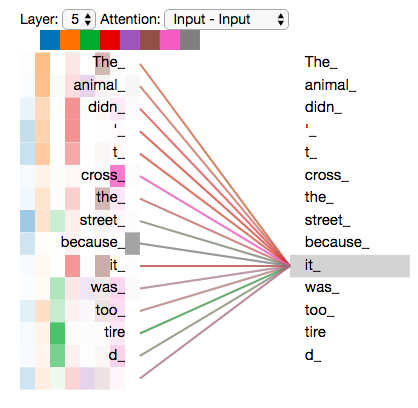

In [ ]:
# Check our tokenized dataset sizes
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3899
    })
    test: Dataset({
        features: ['title', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1671
    })
})

In [ ]:
# Sampe checking
tokenizer(["", "This is a sentence that has words."])

{'input_ids': [[1], [100, 19, 3, 9, 7142, 24, 65, 1234, 5, 1]], 'attention_mask': [[1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

The `preproces_function` is applied on all the elements of all the splits in `dataset`, so our training, validation (we don't have one, but if we did), and testing data will be preprocessed in one single command.

If you're working with smaller data be sure to reduce the default batch size from 1000 to something better suited for smaller data, like we did:

In [ ]:
preprocess_function(dataset['train'][:2])


{'input_ids': [[21603, 10, 86, 48, 1040, 6, 62, 1099, 3, 9, 853, 13, 216, 7, 10488, 686, 13850, 7, 84, 560, 8, 1514, 599, 29, 18, 6982, 3229, 2963, 397, 18, 188, 1167, 2, 15, 2, 60, 13850, 30, 3, 24767, 348, 15710, 388, 99, 1490, 7, 5, 37, 3, 2, 15, 7656, 2, 9, 1884, 23, 2, 1514, 254, 2, 357, 3229, 10014, 11, 8, 6831, 13, 1275, 33, 2127, 5, 1], [21603, 10, 6630, 45, 8340, 4145, 3433, 3, 9, 825, 12, 26926, 1427, 22015, 775, 2704, 34, 8074, 7, 45, 1767, 13562, 5, 818, 1646, 1707, 2097, 224, 38, 301, 518, 371, 6, 7933, 6, 262, 10038, 43, 4162, 1452, 38, 46, 1231, 18836, 12, 8269, 48, 962, 57, 27354, 53, 359, 8755, 13, 625, 4145, 45, 2839, 116, 13643, 126, 6085, 6, 175, 6315, 103, 59, 9248, 1017, 251, 13, 284, 2491, 84, 54, 36, 2471, 12, 1895, 25352, 5, 282, 3, 9, 741, 6, 79, 103, 59, 2643, 168, 12, 508, 18, 6649, 982, 437, 8, 15577, 3172, 11445, 1224, 29690, 5, 389, 3037, 18, 382, 9, 7, 157, 8951, 6789, 447, 1534, 5341, 41, 4555, 476, 15610, 61, 19, 4382, 270, 12, 365, 3180, 1103, 14344, 

## Fine-tuning the model

To instantiate a `Seq2SeqTrainer`, we will need to define three more things. The most important is the [`Seq2SeqTrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training.

## `report_to="wandb"`

By including the parameter `report_to="wandb`" your model's training / fine-tuning progress will be automatically logged to W&B's interactive dashboard.


A multitude of charts on the model's performance, the system metrics (GPU utilization, power consumption, etc.) will be **automatically** generated for you.

Since you're the expert on what you are building you can then select the _most important_ charts for your use case, and with a few mouse clicks, add them to a Report, e.g. [Report: Hyperparameter Search for HuggingFace Transformer Models](https://wandb.ai/matt24/vit-snacks-sweeps/reports/Hyperparameter-Search-for-HuggingFace-Transformer-Models--VmlldzoyMTUxNTg0)

In [ ]:
%env WANDB_PROJECT=cool-summary-arxiv-papers

env: WANDB_PROJECT=cool-summary-arxiv-papers


In [ ]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-base-arxiv",
    #evaluation_strategy = "epoch",
    evaluation_strategy="steps",
    warmup_steps=500,
    eval_steps=1000,
    save_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    logging_steps = 10,
    logging_first_step = True,
    save_total_limit=3,
    save_strategy="steps", # log to W&B every epoch or step
    num_train_epochs=5, #originally 1
    predict_with_generate=True, #<---------- generates summaries
    fp16=True, #<--- small speed 'bonus' from floating pt 16 bit
    push_to_hub=False,
    report_to="wandb",
    run_name="baseline-model",
)

data_collator= DataCollatorForSeq2Seq(tokenizer, model= model)

PyTorch: setting up devices


# What's the ROUGE metric?

It's based on a few 'old school' NLP concepts: bigrams, trigrams, etc. and is a "gist-y" way of measuring how true to the training data a summary text is. https://en.wikipedia.org/wiki/ROUGE_(metric)

In [ ]:
import nltk
import numpy as np

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#rouge metric score compares the actual summary to the produced summary
rouge_score= evaluate.load('rouge')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )

We then just need to pass all of this along with our datasets into the `Seq2SeqTrainer`:

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using cuda_amp half precision backend


We can now finetune our model by calling the `train` method! 

In [ ]:
trainer.train()  # start training and logging to W&B

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: title, abstract. If title, abstract are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3899
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1220
  Number of trainable parameters = 60506624
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

Links: 

https://wandb.ai/events/cool-summary-arxiv-papers/runs/2bknzo0d?workspace=user-andrea0

In [ ]:
# Make sure to finish your run (Notebook only)
wandb.finish()

train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/learning_rate,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/loss,▇██▇▇▇▆▇▇▇▆▅▆▆▄▅▄▄▃▄▂▂▂▂▂▁▁▁
train/epoch,1.11
train/global_step,270
train/learning_rate,1e-05
train/loss,3.192


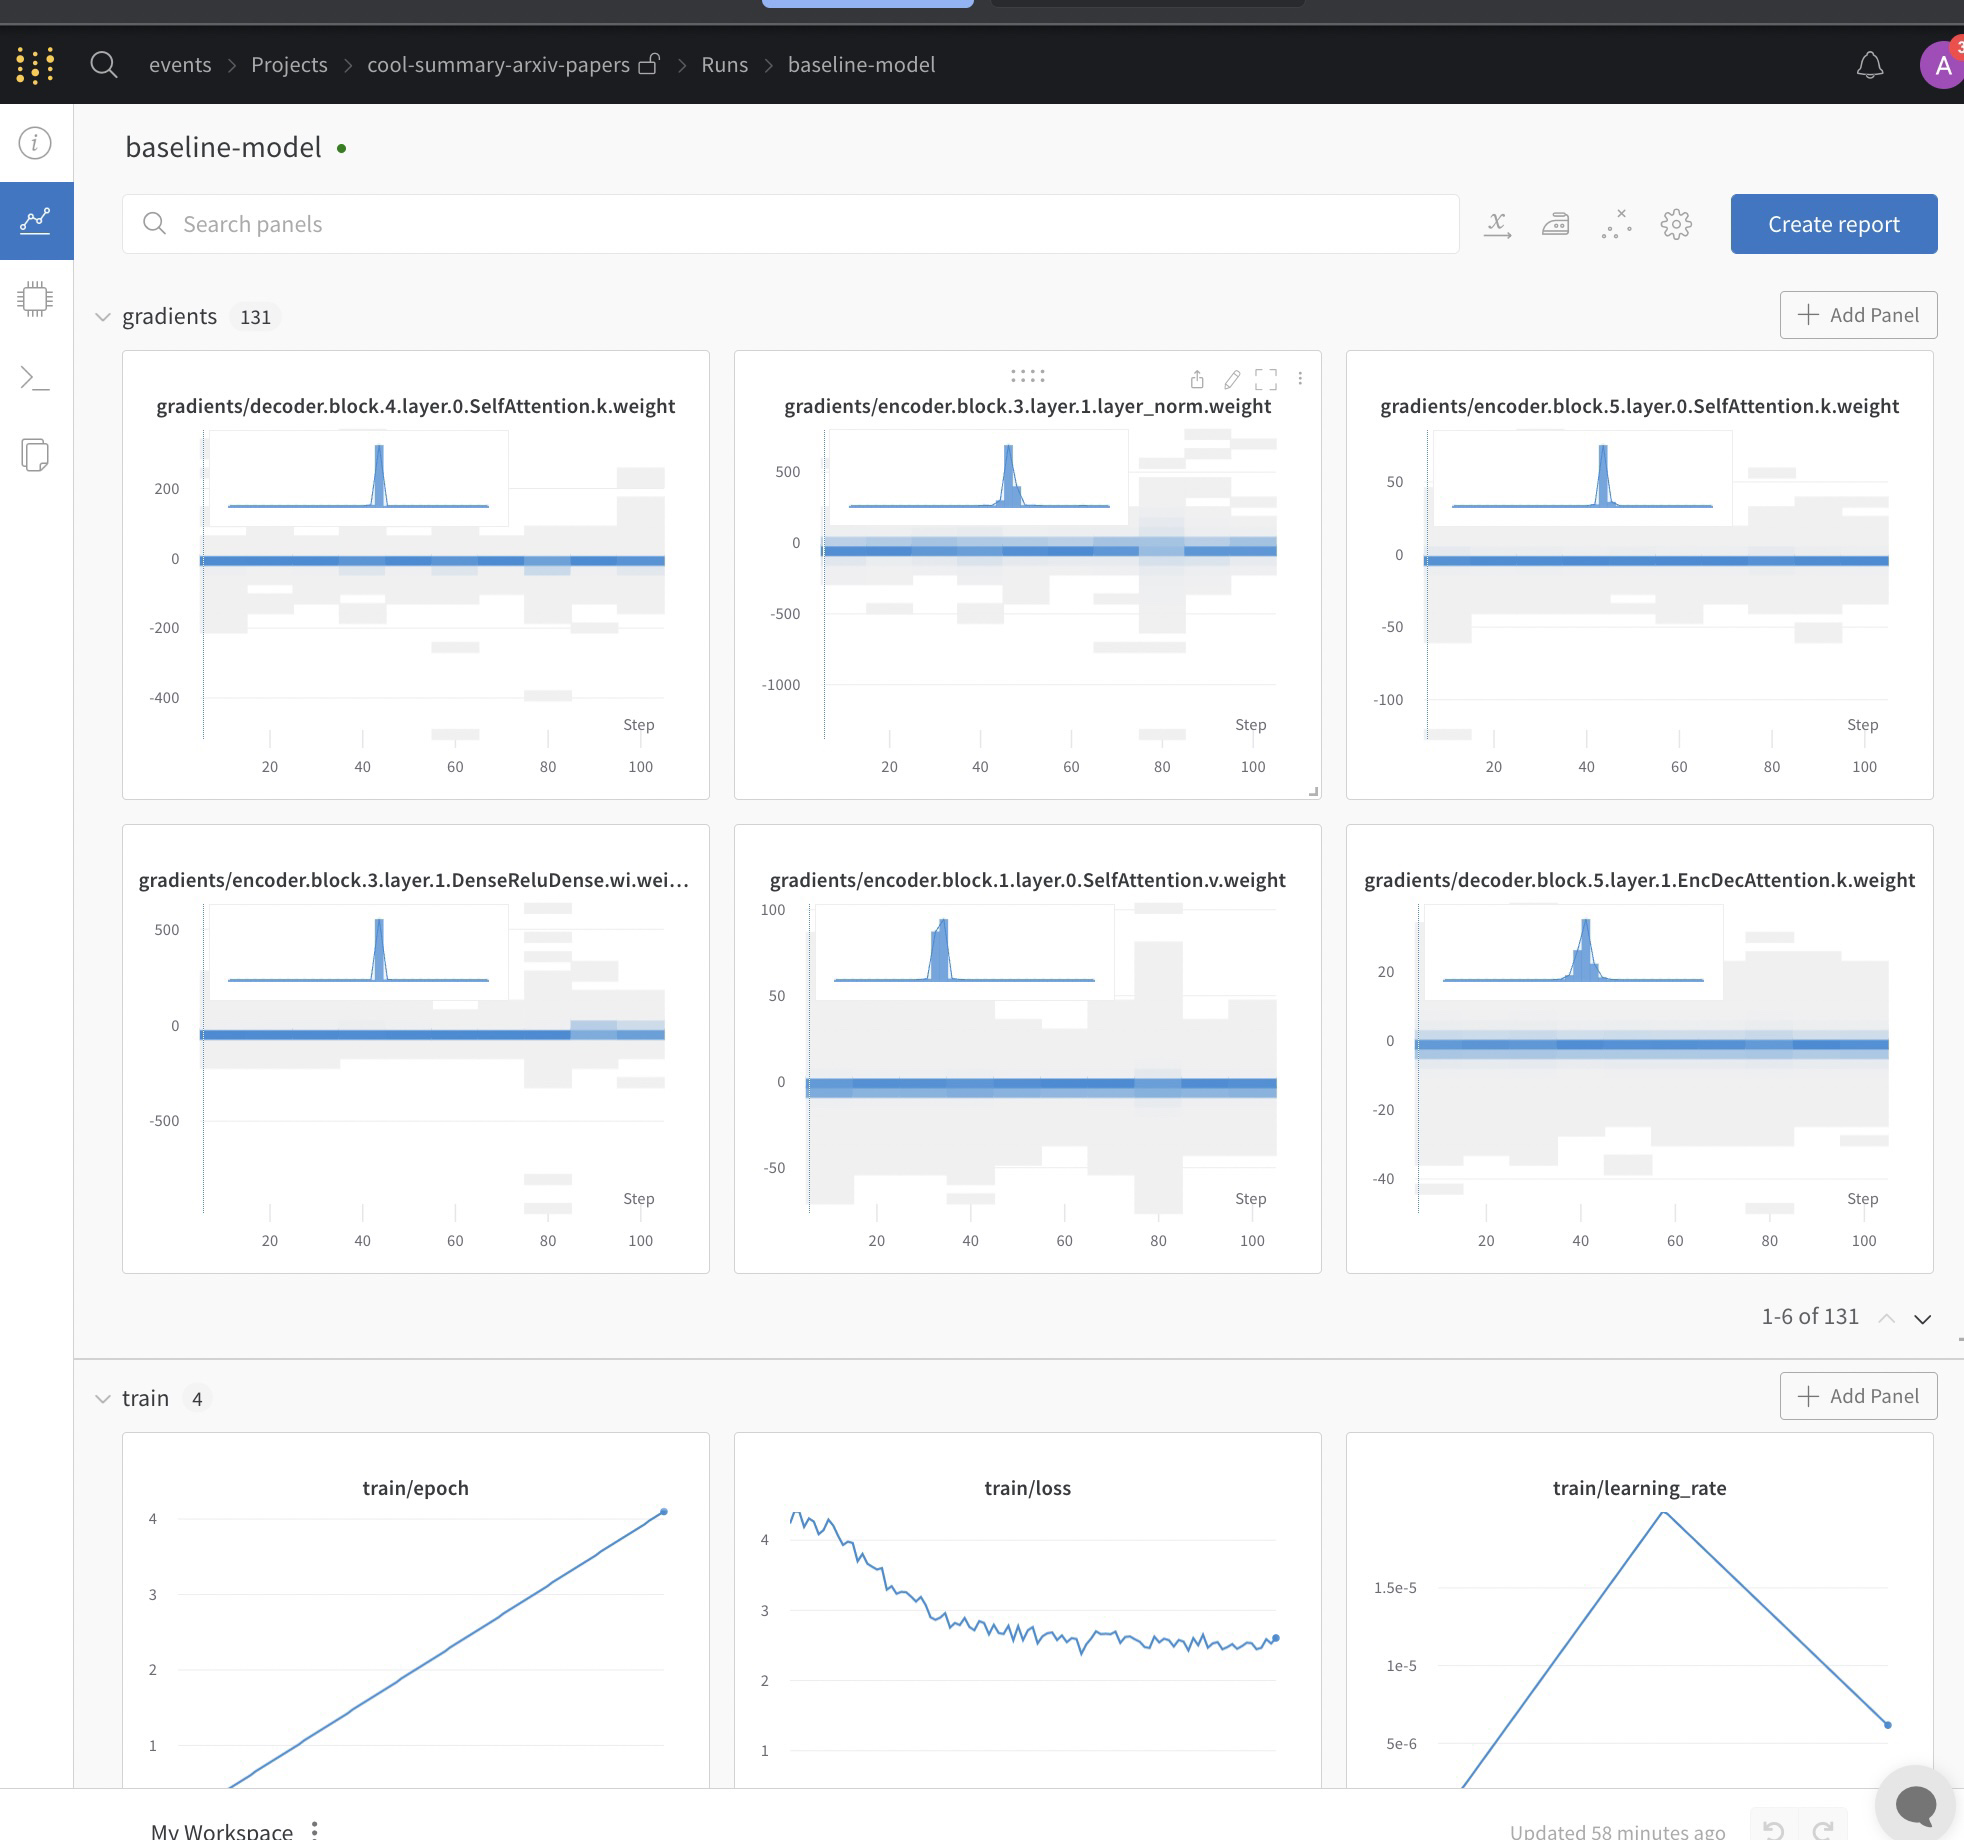

# Copy of the dataset with the new paper title summaries that we load into Pinecone

Download a copy of the dataset with the newly generated paper titles here:

```python
import wandb
run = wandb.init()
artifact = run.use_artifact('events/paper-summaries-demo/test-dataset-for-pinecone:v0', type='dataset')
artifact_dir = artifact.download()
```

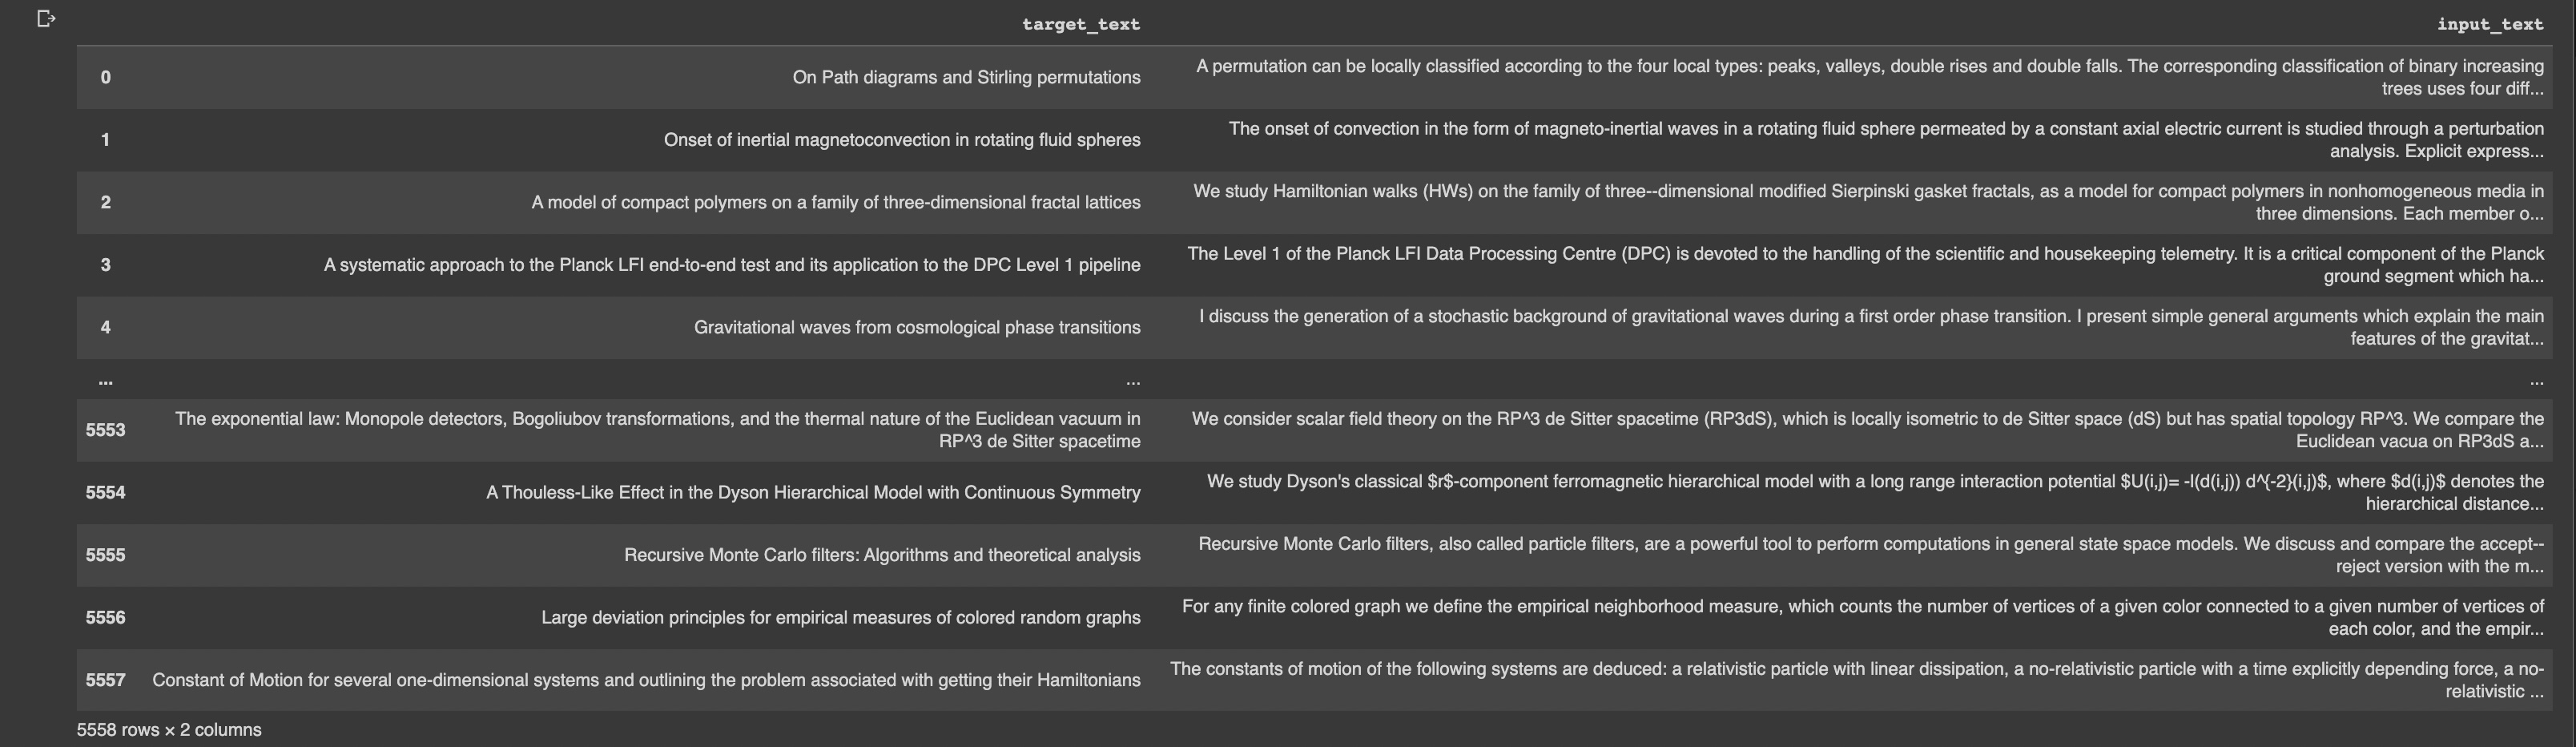

# Saving your model to `Artifacts`

In [ ]:
!mkdir /content/saved_model
trainer.save_model("/content/saved_model")

Saving model checkpoint to /content/saved_model
Configuration saved in /content/saved_model/config.json
Model weights saved in /content/saved_model/pytorch_model.bin
tokenizer config file saved in /content/saved_model/tokenizer_config.json
Special tokens file saved in /content/saved_model/special_tokens_map.json


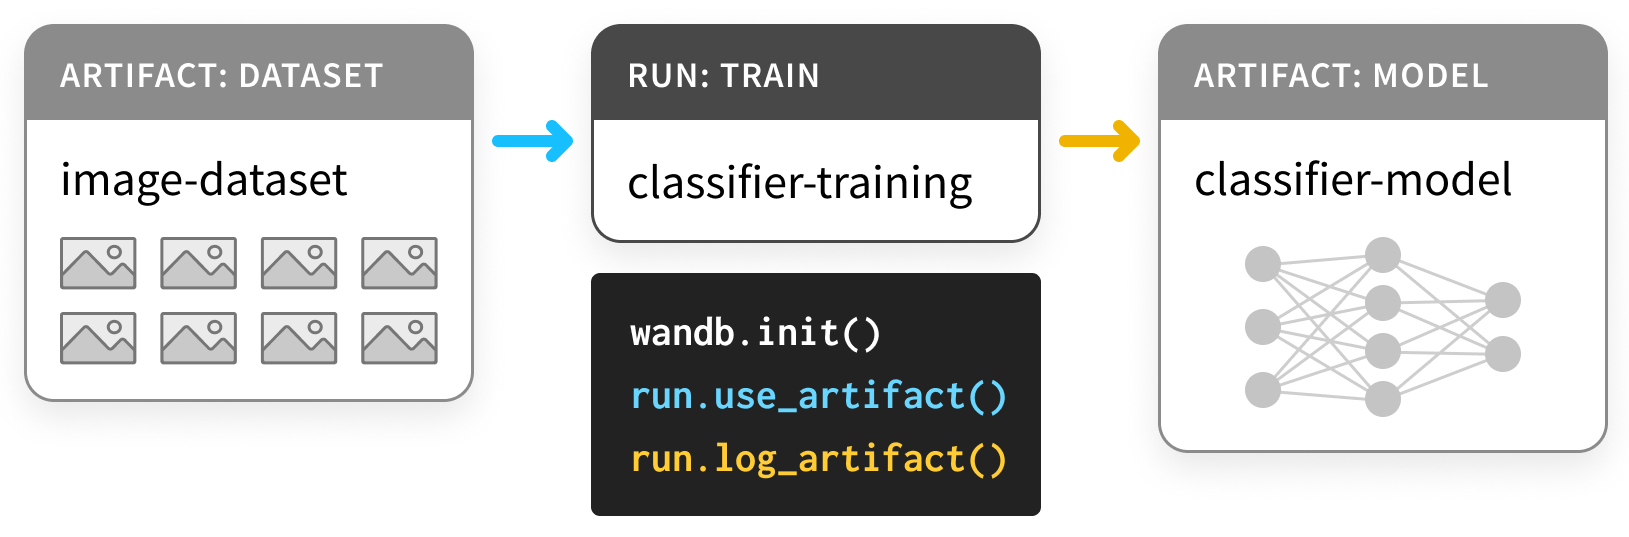

In [ ]:
# Initialize a new W&B run to track this job
run = wandb.init(project="paper-summaries-demo") # Can specify (project="artifacts-quickstart", job_type="dataset-creation")

# Create a new artifact, which is a fine-tuned-model type
ftmodel = wandb.Artifact(name='fine-tuned-arxiv-model', type='fine-tuned-model')
# Add files to the artifact
ftmodel.add_dir(local_path="/content/saved_model")
# Log the artifact to save it as an output of this run
run.log_artifact(ftmodel)

wandb.finish()

wandb: Adding directory to artifact (/content/saved_model)... Done. 0.6s


# Appendix - Sweeps

- How to start up a Sweep
- How to output Sweeps results to share with others via a [Report](https://wandb.ai/site/reports)




<img src="https://i.imgur.com/UFST2NY.png" width="650" />

## Starting up a Sweep

Take a candidate model and run Hyperparameter Sweeps with the click of button. 

You can also programatically run sweeps: https://docs.wandb.ai/guides/sweeps

Sample Sweeps page: https://wandb.ai/events/huggingface/sweeps/rk3kvs9j?workspace=user-andrea0




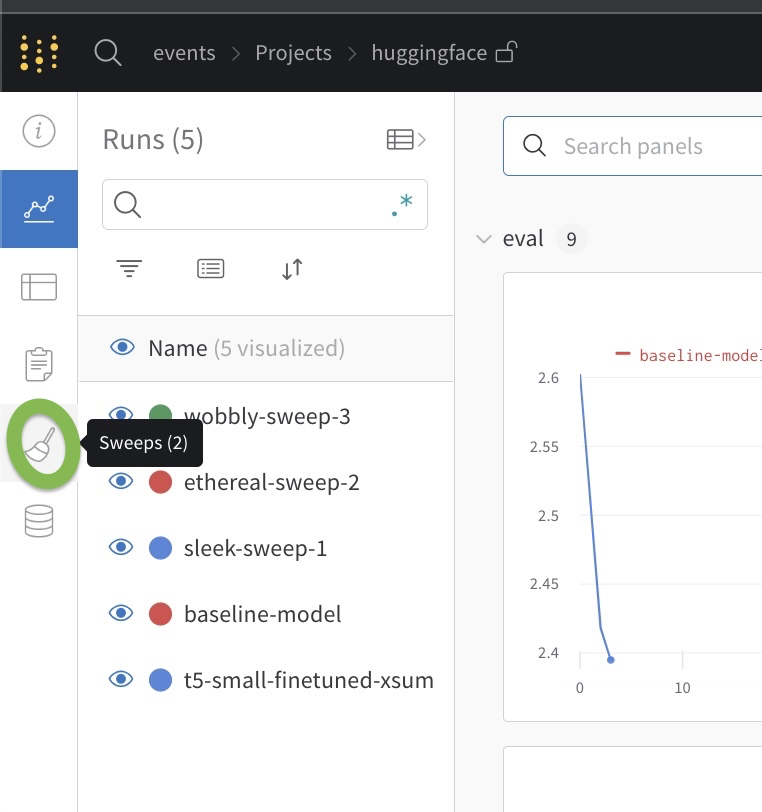

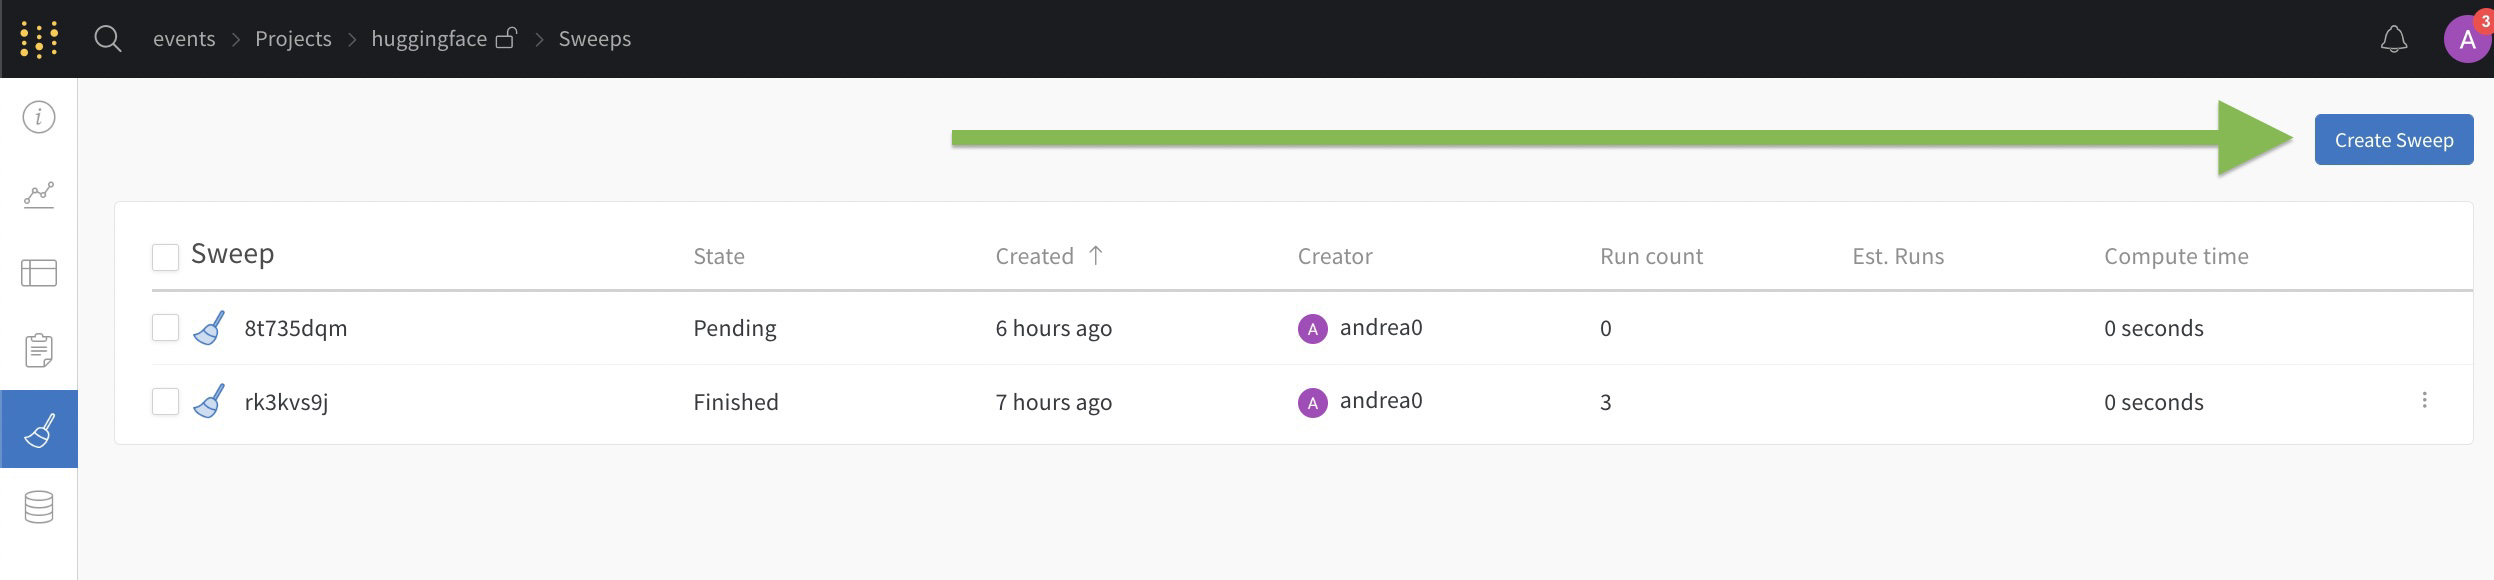

# Similar projects from other W&B users



For a similar project by another Weights & Biases user please see their interactive dashboard ([link](https://wandb.ai/wandb/SimpleTransformers-QA?workspace=user-prashanthkurella))

And a Report from another W&B user on `SimpleTransformers`: [SimpleTransformers Made Easy](https://wandb.ai/wandb/gallery/reports/SimpleTransformers-Transformers-Made-Easy--VmlldzoyNDQzNTg)

<img src="https://i.imgur.com/60KMnvE.png" width="650" />

# Appendix

Uploading our data to Pinecone